In [105]:
import sys
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from rich.table import Table
from IPython.display import display

sys.path.append(str(Path("../scripts/generate").absolute()))
from gridsearch_classifier_params import load_dataframe, get_sample

In [3]:
%cd ..
df = load_dataframe("granite")
sample = pl.concat([
    get_sample(_df, n=400, random_state=0)
    for _df in df.partition_by("primary_category", maintain_order=True)
])
%cd notebooks

/home/wingillis/dev/clean-email
Loaded dataframe with shape: (42973, 15)
/home/wingillis/dev/clean-email/notebooks


In [4]:
models = {
    "svc": SVC(probability=True, class_weight="balanced", tol=1e-2),
}

# Test on validation data (out-of-distribution samples)

In [ ]:
fit_df = pl.read_parquet(
    "../classifier_grid_search/granite_model_selection_results.parquet"
)
top = fit_df.sort("mean_test_score", descending=True)[0].to_dicts()[0]
params = eval(top["params"])
model_type = top["model"]
assert model_type == "svc"

In [ ]:
pipe = Pipeline(
    [("pca", PCA()), ("scaler", StandardScaler()), ("model", models[model_type])]
).set_params(**params)

pipe = pipe.fit(
    sample["snowflake_embedding_clean"].to_numpy(),
    sample["primary_category"].to_numpy(),
)

In [ ]:
# remove entries from sample
out_of_distribution = df.join(
    sample.select(["subject", "from", "body", "date"]),
    how="anti",
    on=["subject", "from", "body", "date"],
)

preds = pipe.predict(out_of_distribution["snowflake_embedding_clean"].to_numpy())

In [13]:
out_of_distribution["primary_category"].unique()

primary_category
str
"""Promotional emails"""
"""Personal or professional corre…"
"""Shopping and order confirmatio…"
"""Programming, educational, and …"
"""Account security and privacy"""
"""News alerts and newsletters"""
"""Travel, scheduling and calenda…"
"""Financial information"""


In [37]:
with pl.Config(tbl_rows=15):
    display(pl.Series("predicted_category", np.unique(preds)))

predicted_category
str
"""Account security and privacy"""
"""Customer service and support"""
"""Financial information"""
"""Medical information"""
"""News alerts and newsletters"""
"""Other"""
"""Personal or professional corre…"
"""Programming, educational, and …"
"""Promotional emails"""


In [ ]:
float(
    balanced_accuracy_score(
        out_of_distribution["primary_category"].to_numpy(), preds, adjusted=True
    )
)

/home/wingillis/dev/clean-email/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.8334838927940924

In [ ]:
f1_score(out_of_distribution["primary_category"].to_numpy(), preds, average="weighted")

0.7934044897670144

In [ ]:
log_probs = pipe.predict_log_proba(
    out_of_distribution["snowflake_embedding_clean"].to_numpy()[:250]
)

In [19]:
def entropy(log_probs):
    return -np.sum(np.exp(log_probs) * log_probs, axis=1)

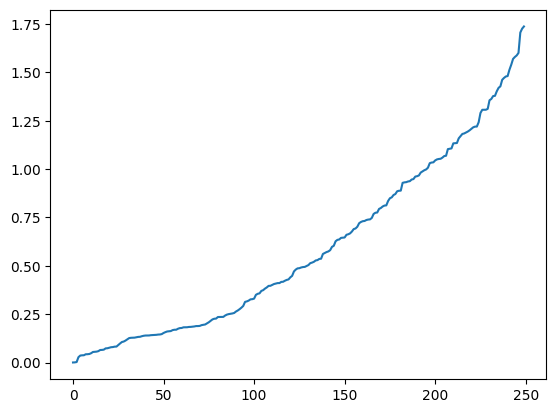

In [52]:
entropies = entropy(log_probs)
sorted_inds = np.argsort(entropies)
plt.plot(np.sort(entropies))

In [53]:
def create_confidence_output(log_probs, model, n_show=4):
    table = Table(show_header=True, header_style="bold magenta")
    table.add_column("Confidence", justify="right")
    table.add_column("Category", justify="left")
    sorted_idx = np.argsort(log_probs)[::-1][:n_show]
    probs = np.exp(log_probs[sorted_idx])[:n_show] * 100
    for pct, cat in zip(probs, model.classes_[sorted_idx]):
        table.add_row(f"{pct:0.0f}%", cat)
    return table

In [54]:
for i in range(5):
    idx = int(sorted_inds[i])
    display(create_confidence_output(log_probs[idx], pipe))

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Confidence ┃ Category                               ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       100% │ Shopping and order confirmations       │
│         0% │ Travel, scheduling and calendar events │
│         0% │ Customer service and support           │
│         0% │ Account security and privacy           │
└────────────┴────────────────────────────────────────┘

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Confidence ┃ Category                               ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       100% │ Shopping and order confirmations       │
│         0% │ Travel, scheduling and calendar events │
│         0% │ Customer service and support           │
│         0% │ Promotional emails                     │
└────────────┴────────────────────────────────────────┘

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Confidence ┃ Category                               ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       100% │ Shopping and order confirmations       │
│         0% │ Travel, scheduling and calendar events │
│         0% │ Customer service and support           │
│         0% │ Financial information                  │
└────────────┴────────────────────────────────────────┘

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Confidence ┃ Category                     ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       100% │ Financial information        │
│         0% │ Account security and privacy │
│         0% │ Promotional emails           │
│         0% │ Customer service and support │
└────────────┴──────────────────────────────┘

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Confidence ┃ Category                     ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       100% │ Financial information        │
│         0% │ Account security and privacy │
│         0% │ Promotional emails           │
│         0% │ Customer service and support │
└────────────┴──────────────────────────────┘

In [55]:
for i in range(1, 6):
    idx = int(sorted_inds[-i])
    display(create_confidence_output(log_probs[idx], pipe))

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Confidence ┃ Category                                            ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        34% │ Promotional emails                                  │
│        18% │ Programming, educational, and technical information │
│        18% │ Personal or professional correspondence             │
│        16% │ News alerts and newsletters                         │
└────────────┴─────────────────────────────────────────────────────┘

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Confidence ┃ Category                                            ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        47% │ Account security and privacy                        │
│        14% │ Personal or professional correspondence             │
│        14% │ Programming, educational, and technical information │
│         7% │ Medical information                                 │
└────────────┴─────────────────────────────────────────────────────┘

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Confidence ┃ Category                                ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        37% │ Account security and privacy            │
│        28% │ Other                                   │
│        12% │ Personal or professional correspondence │
│         7% │ News alerts and newsletters             │
└────────────┴─────────────────────────────────────────┘

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Confidence ┃ Category                         ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        52% │ Promotional emails               │
│        18% │ Account security and privacy     │
│         7% │ Shopping and order confirmations │
│         6% │ Customer service and support     │
└────────────┴──────────────────────────────────┘

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Confidence ┃ Category                                            ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        42% │ Promotional emails                                  │
│        24% │ Programming, educational, and technical information │
│        16% │ Account security and privacy                        │
│         8% │ Personal or professional correspondence             │
└────────────┴─────────────────────────────────────────────────────┘

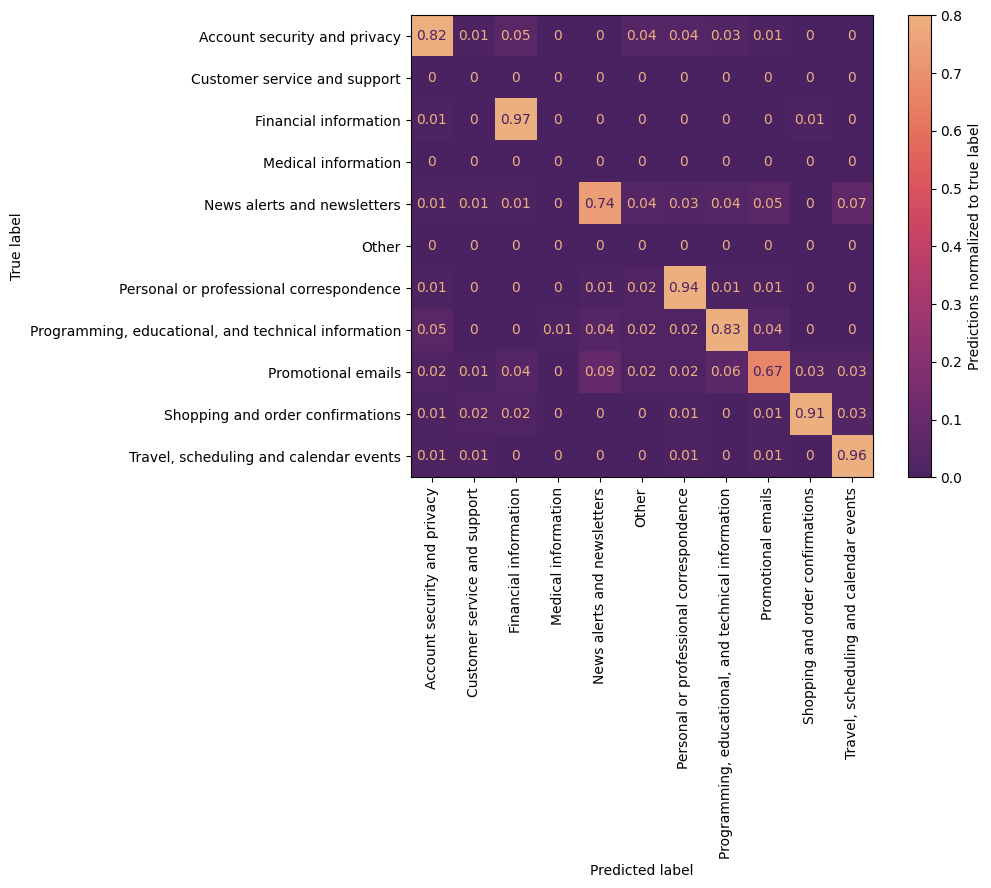

In [122]:
conf_mtx = confusion_matrix(
    out_of_distribution["primary_category"].to_numpy(), preds, normalize="true"
)
conf_mtx = np.round(conf_mtx, 2)
fig = plt.figure(figsize=(9, 6))
cmd = ConfusionMatrixDisplay(conf_mtx, display_labels=pipe.classes_).plot(
    xticks_rotation="vertical", colorbar=False, ax=plt.gca(), cmap="flare_r", im_kw=dict(vmax=0.8)
)
cb = cmd.figure_.colorbar(
    cmd.im_, label="Predictions normalized to true label", ax=cmd.ax_
)